## Import All modules

In [1]:
# importing sys
import sys

# adding Folder_2 to the system path
sys.path.insert(0, '/home/jeongeun/faster_rcnn_rilab')

In [2]:
# AI2 THOR
!pkill thor_*
import ai2thor
from ai2thor.controller import Controller,BFSController
from ai2thor.platform import CloudRendering
from ithor_tools.vis_tool import *
from ithor_tools.transform import cornerpoint_projection,depth2world
from ithor_tools.map2 import single_scenemap
from ithor_tools.landmark_utils import gather,vis_panorama,Word_Dict,choose_ladmark
import random
import math
from IPython.display import display
from moviepy.editor import ImageSequenceClip,VideoFileClip

# Co occurance module
from co_occurance.comet_co import co_occurance_score
from co_occurance.move import co_occurance_based_schedular

# Planning Module
from RRT import gridmaprrt as rrt
from RRT import gridmaprrt_pathsmoothing as smoothing
from IPython.display import Image as IM

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
# Detector module
from data.phase_1 import load_voc_instances,VOC_CLASS_NAMES
import torch
import cv2
import copy
import matplotlib.pyplot as plt
from structures.box import Boxes
from engine.predictor import DefaultPredictor

from  config.config import get_cfg
from model.rcnn import GeneralizedRCNN
from detector.postprocess import postprocess,plot_openset,plot_candidate

## Matching Module
from detector.query_matching import matcher

## Setup AI2THOR

In [4]:
gridSize=0.05

controller = Controller(
    platform = CloudRendering,
    agentMode="locobot",
    visibilityDistance=5.0,
    scene = "FloorPlan_Train11_4",
    gridSize=gridSize,
    movementGaussianSigma=0,
    rotateStepDegrees=90,
    rotateGaussianSigma=0,
    renderClassImage = True,
    renderDepthImage=False,
    renderInstanceSegmentation=False,
    width=300,
    height=300,
    fieldOfView=60
)

INFO - 2022-05-17 01:57:12,722 - controller - Initialize return: {'cameraNearPlane': 0.10000000149011612, 'cameraFarPlane': 20.0}


In [5]:
controller.reset(
    # makes the images a bit higher quality
    width=800,
    height=800,

    # Renders several new image modalities
    renderDepthImage=True,
    renderClassImage = True,
    renderSemanticSegmentation=False,
    renderNormalsImage=False
)
scene_bounds = controller.last_event.metadata['sceneBounds']['center']
controller.step(
    action="AddThirdPartyCamera",
    position=dict(x=scene_bounds['x'], y=5.0, z=scene_bounds['z']),
    rotation=dict(x=90, y=0, z=0),
    orthographic=True,
    orthographicSize= 5.0, fieldOfView=100,
    skyboxColor="white"
)
controller.step(dict(action='GetReachablePositions'))
rstate = controller.last_event.metadata['actionReturn']

controller.step(
    action="Teleport",
    position = rstate[100]
)

pos = controller.last_event.metadata['agent']['position']
pos = [pos['x'],pos['z']]
objects = controller.last_event.metadata['objects']

In [6]:
df = show_objects_table(objects)
df

Object Metadata. Not showing objectOrientedBoundingBox, axisAlignedBoundingBox, and receptacleObjectIds for clarity.


,objectType,objectId,name,position[x],position[y],position[z],rotation[x],rotation[y],rotation[z],distance,...,openness,pickupable,isPickedUp,moveable,mass,salientMaterials,assetId,parentReceptacles,controlledObjects,isMoving
0,Box,Box|+01.32|+00.24|-02.71,Box_12,1.3250,0.2405,-2.7123,-0.0024,0.0002,0.0001,2.1809,...,1.0,True,False,False,0.30,[Paper],Box_12,[Floor|+00.00|+00.00|+00.00],None,False
1,Statue,Statue|+09.25|+00.74|-02.78,Waving_Statue_2,9.2529,0.7415,-2.7845,0.0797,218.3742,0.0788,6.5747,...,0.0,True,False,False,1.00,[Stone],Waving_Statue_2,[DiningTable|+09.01|+00.00|-03.00],None,False
2,AlarmClock,AlarmClock|+01.28|+00.48|-04.63,Alarm_Clock_24,1.2835,0.4783,-4.6341,0.0081,60.0002,-0.0022,3.7079,...,0.0,True,False,False,0.80,"[Metal, Plastic, Glass]",Alarm_Clock_24,"[SideTable|+01.23|+00.00|-04.66, Floor|+00.00|...",None,False
3,Bottle,Bottle|+08.37|+00.74|-03.32,Bottle_1,8.3749,0.7416,-3.3181,359.8951,0.1398,0.0140,5.8841,...,0.0,True,False,False,0.20,[Glass],Bottle_1,[DiningTable|+09.01|+00.00|-03.00],None,False
4,Laptop,Laptop|+01.71|+00.35|-01.61,Laptop_24,1.7095,0.3512,-1.6118,347.3984,120.3624,359.9260,1.3039,...,1.0,True,False,False,2.30,"[Metal, Plastic, Glass]",Laptop_24,"[ArmChair|+01.62|+00.00|-01.54, Floor|+00.00|+...",[],True
5,FloorLamp,FloorLamp|+04.23|00.00|-03.09,Floor_Lamp_21,4.2270,-0.0010,-3.0870,0.0054,0.0013,0.0140,2.4297,...,0.0,False,False,True,3.93,[Metal],Floor_Lamp_21,[Floor|+00.00|+00.00|+00.00],[],True
6,BasketBall,BasketBall|+01.13|+00.12|-04.34,Basketball_1,1.1323,0.1200,-4.3409,-0.0000,-0.0000,43.4934,3.5787,...,0.0,True,False,False,0.60,[Rubber],Basketball_1,[Floor|+00.00|+00.00|+00.00],None,False
7,BaseballBat,BaseballBat|+06.13|+00.68|-01.11,BaseballBat_2,6.1279,0.6817,-1.1069,349.2352,180.1767,179.9622,3.2908,...,0.0,True,False,False,0.90,[Wood],BaseballBat_2,[Floor|+00.00|+00.00|+00.00],None,True
8,RemoteControl,RemoteControl|+03.13|+00.40|-02.91,Remote_3,3.0937,0.3978,-2.9120,359.8734,152.8315,0.4237,1.7062,...,0.0,True,False,False,0.15,"[Metal, Plastic]",Remote_3,"[CoffeeTable|+02.43|+00.00|-02.78, Floor|+00.0...",None,True
9,SaltShaker,SaltShaker|+03.14|+00.40|-02.57,Salt_Shaker_2,3.0966,0.3958,-2.5770,0.1379,0.8948,359.6768,1.3953,...,0.0,True,False,False,0.60,"[Metal, Glass]",Salt_Shaker_2,"[CoffeeTable|+02.43|+00.00|-02.78, Floor|+00.0...",None,True


## Make Object Query

In [7]:
landmarks,visible_landmark_name = choose_ladmark(objects)
landmark_cat = [Word_Dict[l] for l in visible_landmark_name]
# query_object = random.choice(objects)
query_object = objects[16] #20
query_object_name = query_object['objectType']

print(query_object_name)

Pillow


## Setup Co occurance

In [8]:
co_occurance_scoring = co_occurance_score(landmark_cat,'cuda:0')


model loading ...


INFO - 2022-05-17 01:57:21,233 - utils - using task specific params for summarization: {'early_stopping': True, 'length_penalty': 2.0, 'max_length': 24, 'min_length': 1, 'no_repeat_ngram_size': 3, 'num_beams': 4}


model loaded


0.6868000030517578 10.446799278259277 -5.351839542388916 0.5981607437133789
0
(418, 713, 4)


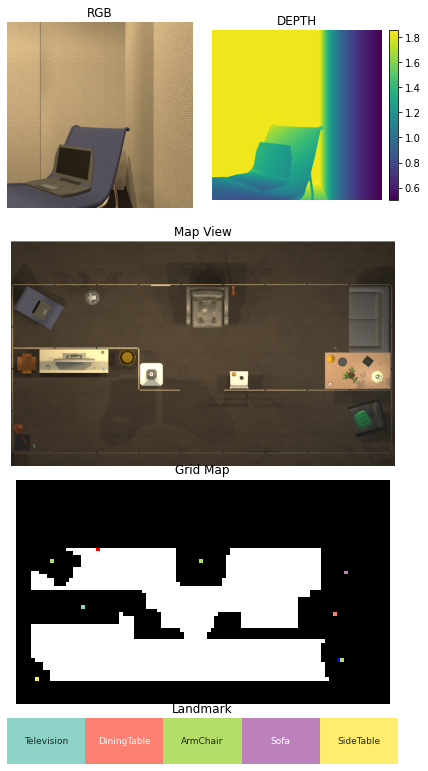

In [9]:
scene_bounds = controller.last_event.metadata['sceneBounds']['cornerPoints']
scene_bounds = cornerpoint_projection(scene_bounds)

sm = single_scenemap(scene_bounds,rstate,stepsize = 0.1,
                landmark_names=visible_landmark_name,landmarks=landmarks)
landmark_config = dict(name=visible_landmark_name,color = sm.landmark_colors)
imshow_grid = sm.plot(controller.last_event.metadata['agent']['position'],query_object['position'])
plot_frames(controller.last_event,imshow_grid,landmark_config)

## Setup Detector

In [10]:
'''
config file
'''

print(torch.cuda.device_count())
torch.cuda.set_device(0)
print(torch.cuda.current_device())
cfg = get_cfg()
cfg.merge_from_file('../faster_rcnn_rilab/config_files/voc.yaml')
cfg.MODEL.SAVE_IDX=19
cfg.MODEL.RPN.USE_MDN=False
cfg.log = False 
cfg.MODEL.ROI_HEADS.USE_MLN = True
cfg.MODEL.ROI_HEADS.AUTO_LABEL = False
cfg.MODEL.ROI_HEADS.AF = 'baseline'
cfg.MODEL.RPN.AUTO_LABEL = False
cfg.MODEL.ROI_BOX_HEAD.USE_FD = False
cfg.MODEL.RPN.AUTO_LABEL_TYPE = 'sum'
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 21
cfg.INPUT.RANDOM_FLIP = "none"
cfg.MODEL.ROI_HEADS.UNCT = True
cfg.PATH = '../faster_rcnn_rilab'

# cfg.merge_from_list(args.opts)
RPN_NAME = 'mdn' if cfg.MODEL.RPN.USE_MDN else 'base'
ROI_NAME = 'mln' if cfg.MODEL.ROI_HEADS.USE_MLN else 'base'
MODEL_NAME = RPN_NAME + ROI_NAME
# cfg.merge_from_list(args.opts)
cfg.freeze()
# wandb.init(config=cfg,tags= 'temp',name = 'temp',project='temp')

2
0


In [11]:
device = 'cuda:0'
model = GeneralizedRCNN(cfg,device = device).to(device)
state_dict = torch.load('../faster_rcnn_rilab/ckpt/{}/{}_{}_15000.pt'.format(cfg.MODEL.ROI_HEADS.AF,cfg.MODEL.SAVE_IDX,MODEL_NAME),map_location=device)
pretrained_dict = {k: v for k, v in state_dict.items() if k in model.state_dict()}
model.load_state_dict(pretrained_dict)

predictor = DefaultPredictor(cfg,model)

WARNING - 2022-05-17 01:57:22,556 - warnings - /home/jeongeun/faster_rcnn_rilab/model/rpn/rpn.py:45: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  nn.init.normal(layers.weight,std=0.01)

WARNING - 2022-05-17 01:57:22,604 - warnings - /home/jeongeun/faster_rcnn_rilab/model/rpn/rpn.py:46: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  nn.init.normal(layers.bias,0)



WARNING - 2022-05-17 01:57:23,436 - warnings - /home/jeongeun/.pyenv/versions/det/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)



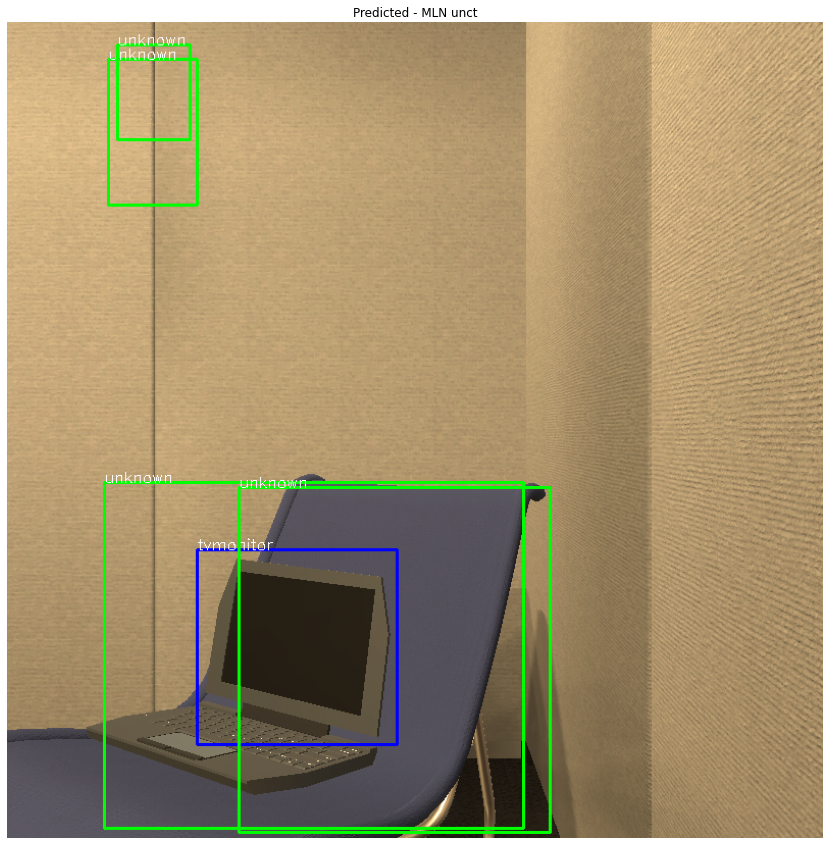

In [12]:
'''
Example of Openset Detection
'''
VOC_CLASS_NAMES = (
    "aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat",
    "chair", "cow", "diningtable", "dog", "horse", "motorbike", "person",
    "pottedplant", "sheep", "sofa", "train", "tvmonitor", 'unknown'
)

img = controller.last_event.cv2img
pred = predictor(img)
pred_boxes, pred_classes = postprocess(pred)
plot_openset(img,pred_boxes,pred_classes,VOC_CLASS_NAMES)

In [13]:
'''
Load Matcher
'''
query_matcher = matcher(query_object_name,threshold=29,device = device)

a photo of a pillow


## Co-occurance Score

In [14]:
thres = 0.6
res = co_occurance_scoring.score(query_object_name)
if max(res)<thres:
    thres = max(res)-0.001

WARNING - 2022-05-17 01:57:28,475 - warnings - /home/jeongeun/ITHOR_Navi/co_occurance/comet_co.py:37: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  sims.append(doc1.similarity(doc2))



[0, 4, 2, 1, 3]


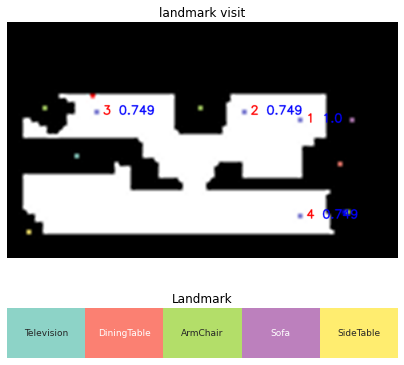

In [15]:
schedular = co_occurance_based_schedular(landmarks,visible_landmark_name)
schedular.get_graph(sm,controller,res,thres)

path = schedular.optimize()
vis_visit_landmark(query_object,path,controller,sm,landmark_config)

## Move To landmark

In [16]:
rrtplanner = rrt.RRT(controller = controller, expand_dis=0.1,max_iter=10000,goal_sample_rate=20)
d2w = depth2world()


In [17]:
'''
Move to inital position
'''
controller.step(
    action="Teleport",
    position = rstate[100]
)

<ai2thor.server.Event at 0x7fd12ee0fa60
    .metadata["lastAction"] = Teleport
    .metadata["lastActionSuccess"] = True
    .metadata["errorMessage"] = "
    .metadata["actionReturn"] = None
>

In [18]:
def detect(frames,single_pos,gt_boxes,controller,predictor,matcher):
    patch = np.zeros((0,256,256,3),dtype=np.uint8)
    map_p = []
    sucesses = 0
    for frame,pos,gt_box in zip(frames,single_pos,gt_boxes):
        pred = predictor(frame)
        pred_boxes, _ = postprocess(pred)
        # plot_openset(frame,pred_boxes,pred_classes,VOC_CLASS_NAMES)
        show_patch,candidate_boxes,sucess = matcher.matching_score(frame,pred_boxes,gt_box)
        sucesses += torch.sum(sucess).item()
        if len(show_patch):
            DEPTH = controller.last_event.depth_frame
            COLOR = controller.last_event.frame.astype(np.uint8)
            map_points = d2w.object_coord(candidate_boxes,DEPTH,COLOR
                                ,pos['pos'],pos['rot'])
            patch = np.concatenate((patch,show_patch),axis=0)
            map_p += map_points
    return patch,map_p,sucesses

[{'x': 8.1, 'y': 0.91, 'z': -1.9000000000000004}, 90, 1.0]
start planning
path found!
end planning


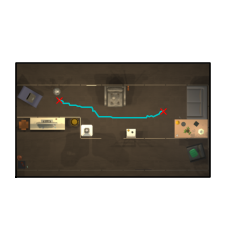

end move
(418, 713, 4)


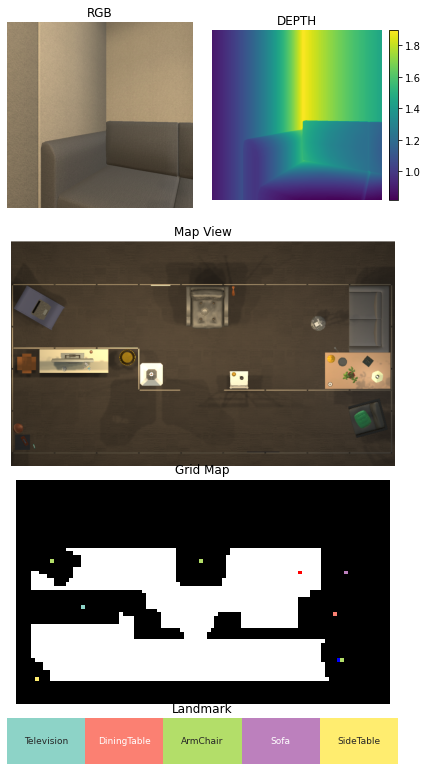

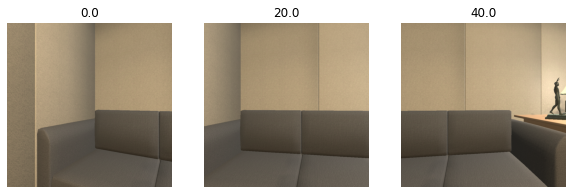

1
[{'x': 6.7, 'y': 0.91, 'z': -1.6000000000000005}, 270, 0.749]
start planning
path found!
end planning


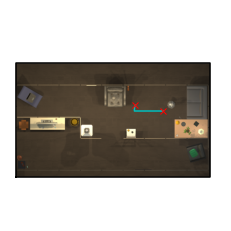

end move
(418, 713, 4)


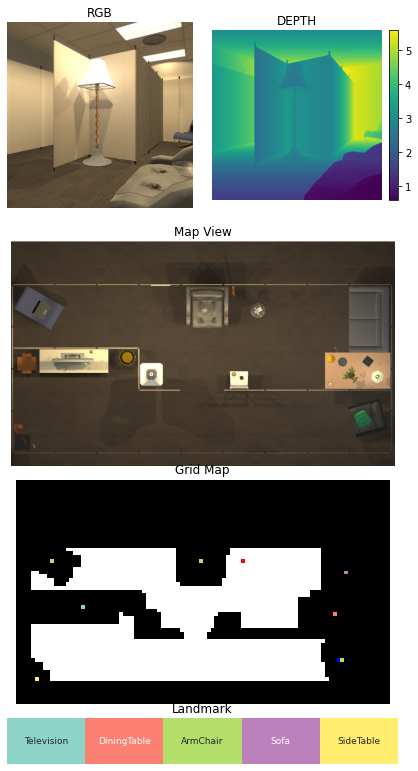

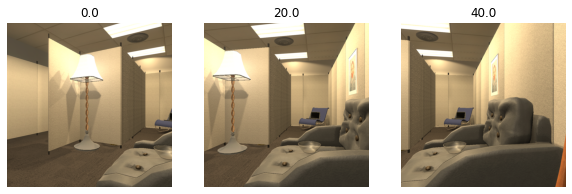

1
[{'x': 2.9000000000000004, 'y': 0.91, 'z': -1.6000000000000005}, 270, 0.749]
start planning
path found!
end planning


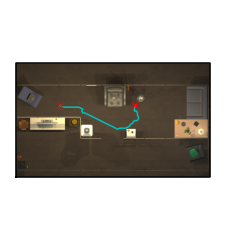

end move
(418, 713, 4)


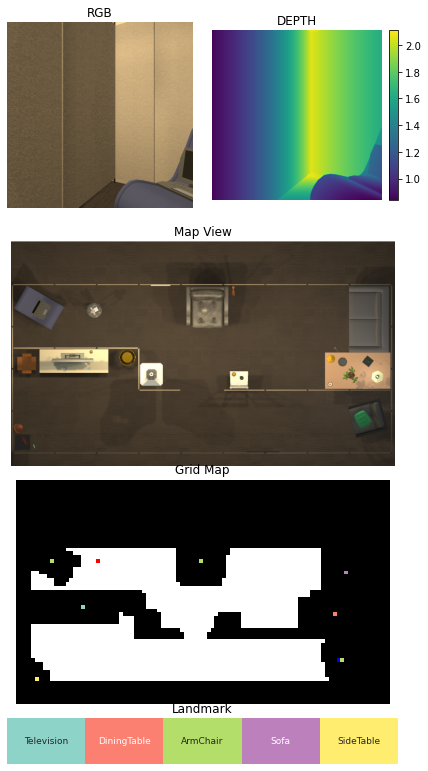

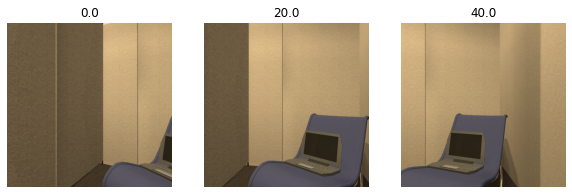

1
[{'x': 8.1, 'y': 0.91, 'z': -4.200000000000001}, 90, 0.749]
start planning
path found!
end planning


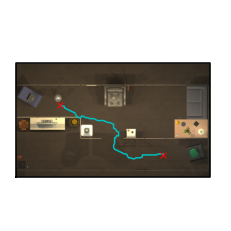

end move
(418, 713, 4)


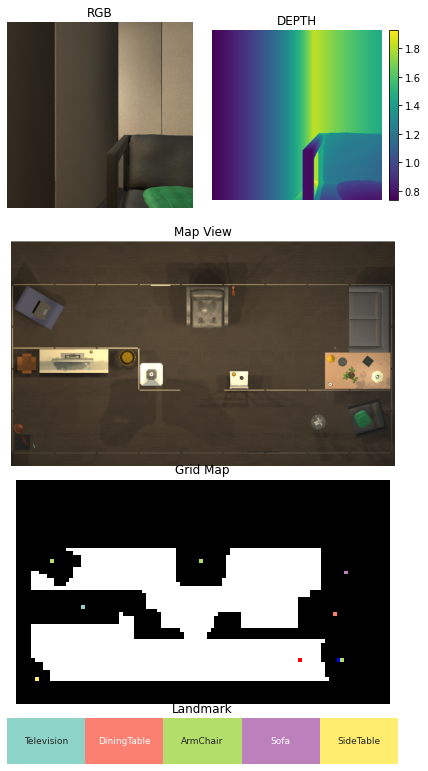

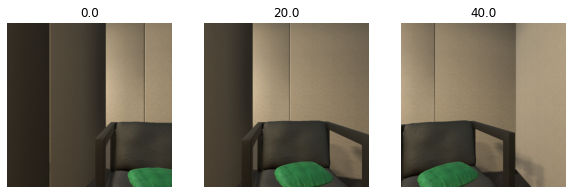

6
Sucess? True
Total Path Length 20.89286661100358


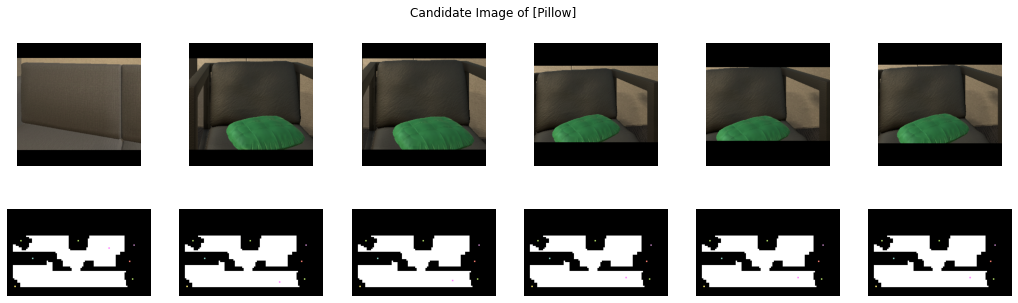

In [19]:
total_patch = np.zeros((0,256,256,3),dtype=np.uint8)
total_mappoints = []
angle = 60
step = 3
total_success = 0
total_path_len = 0
for p in path[1:]:
    print(p)
    pos = controller.last_event.metadata['agent']['position']
    rrtplanner.set_start(pos)
    rrtplanner.set_goal(p[0])
    print("start planning")
    local_path = rrtplanner.planning(animation=False)
    smoothpath = smoothing.path_smoothing(rrtplanner,40,verbose=False)
    print("end planning")
    rrtplanner.plot_path(smoothpath)
    
    flag,path_len,frames = rrtplanner.go_with_teleport(smoothpath,maxspeed=0.2)
    total_path_len += path_len
    # video = ImageSequenceClip(frames, fps=10)
    # video.write_gif('temp.gif')
    # with open('temp.gif','rb') as file:
    #     display(IM(file.read(),width = 300))
    
    pos = controller.last_event.metadata['agent']['position']
    controller.step(
        action="Teleport",
        position = pos, rotation = dict(x=0,y=p[1]-angle/2,z=0)
            )
    print("end move")
    imshow_grid = sm.plot(pos,query_object['position'])
    plot_frames(controller.last_event,imshow_grid,landmark_config)
    frames, single_pos,gt_boxes,gt_vis = gather(controller,query_object['objectType'],step=step,angle=angle)
    candidate_patches, candidate_map_points,sucesses = detect(frames,single_pos,gt_boxes,controller,predictor,query_matcher)
    total_patch = np.concatenate((total_patch,candidate_patches),axis=0)
    total_mappoints += candidate_map_points
    total_success += sucesses
    vis_panorama(frames,res=angle)
    print(len(total_patch))
    if len(total_patch)>7:
        # total_patch = np.concatenate(total_patch,axis=0)
        # print(total_patch.shape,)
        break
print("Sucess?",total_success>0)
print("Total Path Length", total_path_len)
plot_candidate(total_patch,total_mappoints,query_object_name,sm)

In [20]:
SPL = (total_success>0)/total_path_len
print(SPL)

0.04786322617277101


In [21]:
total_success

5